In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
models_dict = {
    "InceptionV3": (models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1), 299),
    "ResNet-18": (models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1), 224),
    "VGG-16": (models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1), 224),
    "MobileNet": (models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1), 224),
    "EfficientNet-B0": (models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1), 224),
    "GoogLeNet": (models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1), 224),
    "AlexNet": (models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1), 224)
}

In [ ]:
def get_transforms(input_size):
    return transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

In [ ]:
train_dir = "/kaggle/input/modlaity-transfer/Modality/train/train"  # Update this path
test_dir = "/kaggle/input/modlaity-transfer/Modality/test/test"  # Update this path

In [ ]:
def load_dataset(input_size):
    transform = get_transforms(input_size)
    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    return train_loader, test_loader, train_dataset.classes

In [ ]:
def train_and_evaluate(model, input_size, model_name):
    train_loader, test_loader, class_names = load_dataset(input_size)
    num_classes = len(class_names)
    
    # Modify last layer for classification
    if "fc" in dir(model):  # For ResNet, EfficientNet, etc.
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif "classifier" in dir(model):  # For VGG, MobileNet
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    elif "AuxLogits" in dir(model):  # For InceptionV3
        model.AuxLogits.fc = nn.Linear(model.AuxLogits.fc.in_features, num_classes)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    epochs = 10
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            if isinstance(outputs, tuple):  # Handle InceptionV3
                outputs = outputs[0]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"{model_name} - Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    # Evaluation
    model.eval()
    y_true, y_pred, y_scores = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(torch.softmax(outputs, dim=1).cpu().numpy())
    
    # Compute metrics
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores, multi_class='ovr')
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"{model_name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")
    
    # Plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()
    
    return accuracy, auc


In [ ]:
results = {}
for model_name, (model, input_size) in models_dict.items():
    print(f"Training {model_name}...")
    acc, auc = train_and_evaluate(model, input_size, model_name)
    results[model_name] = {"Accuracy": acc, "AUC": auc}

print("Final Results:", results)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm

In [15]:
train_dir = "/kaggle/input/modlaity-transfer/Modality/train/train"
test_dir = "/kaggle/input/modlaity-transfer/Modality/test/test"
num_classes = 5 

In [16]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet-B0 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

In [17]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

In [18]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
model = models.efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 134MB/s] 


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct, total = 0, 0
        loop = tqdm(train_loader, leave=True)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=running_loss/total, acc=100*correct/total)
    
    print("Training complete.")

In [23]:
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [24]:
train_model(model, train_loader, criterion, optimizer, num_epochs=10)
test_model(model, test_loader)

Epoch [10/10]: 100%|██████████| 32/32 [00:03<00:00,  8.67it/s, acc=98.2, loss=0.00755]

Training complete.


Test Accuracy: 99.50%


In [25]:
torch.save(model.state_dict(), "efficientnet_b0_modality.pth")  # Save model

In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models

In [26]:
model = models.efficientnet_b0(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)  # 5 classes
model.load_state_dict(torch.load("efficientnet_b0_modality.pth", map_location=device))
model = model.to(device)
model.eval()

<ipython-input-26-000669c10990>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("efficientnet_b0_modality.pth", map_location=device))


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [3]:
class_labels = ["MRI", "OCT", "Lung CT", "Liver CT", "X-ray"]

Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.03it/s]


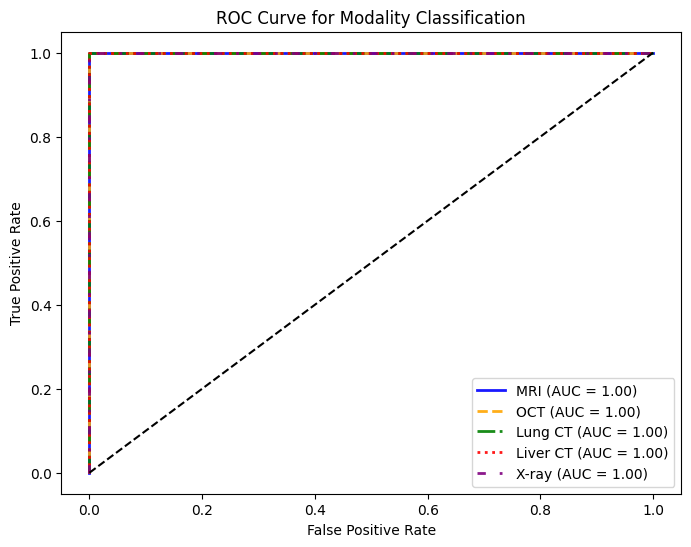

In [30]:
all_labels = []
all_probs = []

# Get Predictions for ROC Curve
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities

        # Convert labels and probabilities to lists before extending
        all_labels += labels.cpu().tolist()
        all_probs += probs.cpu().tolist()

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Compute ROC Curve and AUC for Each Class
# Define different linestyles to separate overlapping curves
linestyles = ['-', '--', '-.', ':', (0, (3, 5, 1, 5))]  
colors = ['b', 'orange', 'g', 'r', 'purple']  # Unique colors for each class

plt.figure(figsize=(8, 6))

for i in range(num_classes):
    # Compute ROC curve
    binary_labels = (all_labels == i).astype(int)
    fpr, tpr, _ = roc_curve(binary_labels, all_probs[:, i])
    roc_auc = auc(fpr, tpr)

    # Plot each class with a different linestyle, color, and transparency
    plt.plot(fpr, tpr, color=colors[i], linestyle=linestyles[i], linewidth=2, alpha=0.9, 
             label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Modality Classification")

# Place legend inside the graph without overlapping
plt.legend(loc="lower right", fontsize=10, frameon=True)

plt.show()